# Apartment prices and venues data analysis in Seoul, South Korea

- Couresa_Capstone Final Project
- Segmenting and clustering neighborhoods in the city of Seoul, Korea
- Correlation analysis between clusters and average apartment prices

## Import Library

In [6]:
#!pip install geopy
#!pip install folium # Successful Install

     |████████████████████████████████| 102kB 9.2MB/s ta 0:00:011


In [88]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import numpy as np

from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import seaborn as sns

## 1. Data Preprocessing

### a. Districts, Geo infomation and the average aptment price (per 3.3m square) of Seoul

In [8]:
# The code was removed by Watson Studio for sharing.

,Division name,Latitude,Longitude,Price_W,Price_D
0,Dobong District,37.6688,127.0471,16140000,13450
1,Dongdaemun District,37.5744,127.0400,23870000,19892
2,Dongjak District,37.5124,126.9393,29860000,24883
3,Eunpyeong District,37.6027,126.9291,20080000,16733
4,Gangbuk District,37.6396,127.0257,18900000,15750


In [9]:
seoul_df=df_data_1.rename(columns={'Division name':'District',' Latitude':'Latitude',' Longitude':'Longitude','Price_D':'Price'})

In [10]:
geo_df=seoul_df[['District','Latitude','Longitude']]
apt_df=seoul_df[['District','Price']]

### b. Districts mapping in Seoul map

In [11]:
# Seoul geo information
address = 'SEOUL, KO'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of SEOUL are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of SEOUL are 37.558144, 126.984157.


In [12]:
# create map of Seoul using latitude and longitude values
map_seoul = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, district in zip(geo_df['Latitude'], geo_df['Longitude'], geo_df['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seoul)  
    
map_seoul

### c. venues using Foursquare

#### Define Foursquare Credentials and Version (hidden cell)

In [13]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: FO0D0V4TDBIGHHPPXTOIXBZ4JX52WEOCJV42OTRYDB2YIMXX
CLIENT_SECRET: MTLJSVCGJRKODMBYDZYHNKJ2RYP0I3TRY4SO4QKAJ2SEBKGF


#### Explore Neighborhoods in Seoul

In [14]:
# function
LIMIT=200
def getNearbyVenues(names, latitudes, longitudes, radius=3000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
# venues
seoul_venues = getNearbyVenues(names=geo_df['District'],
                                   latitudes=geo_df['Latitude'],
                                   longitudes=geo_df['Longitude'])

Dobong District
Dongdaemun District
Dongjak District
Eunpyeong District
Gangbuk District
Gangdong District
Gangnam District
Gangseo District
Geumcheon District
Guro District
Gwanak District
Gwangjin District
Jongno District
Jung District
Jungnang District
Mapo District
Nowon District
Seocho District
Seodaemun District
Seongbuk District
Seongdong District
Songpa District
Yangcheon District
Yeongdeungpo District
Yongsan District


In [16]:
# All venues
print(seoul_venues.shape)
seoul_venues.head()

(2319, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Dobong District,37.6688,127.0471,맥도날드 (McDonald's) (맥도날드),37.672506,127.056115,Fast Food Restaurant
1,Dobong District,37.6688,127.0471,맥도날드 (McDonald's) (맥도날드),37.670196,127.043726,Fast Food Restaurant
2,Dobong District,37.6688,127.0471,방학동 도깨비시장,37.665427,127.035603,Market
3,Dobong District,37.6688,127.0471,WAGEN COFFEE,37.666922,127.045057,Café
4,Dobong District,37.6688,127.0471,수정궁,37.662404,127.032934,Chinese Restaurant


In [17]:
# how many venues were returned for each district
seoul_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Dobong District,69,69,69,69,69,69
Dongdaemun District,100,100,100,100,100,100
Dongjak District,100,100,100,100,100,100
Eunpyeong District,88,88,88,88,88,88
Gangbuk District,77,77,77,77,77,77
Gangdong District,100,100,100,100,100,100
Gangnam District,100,100,100,100,100,100
Gangseo District,90,90,90,90,90,90
Geumcheon District,37,37,37,37,37,37


In [18]:
## The number of venue categories
print('There are {} uniques categories.'.format(len(seoul_venues['Venue Category'].unique())))

There are 192 uniques categories.


## 3. Analysis

### Each District

In [19]:
# one hot encoding
seoul_onehot = pd.get_dummies(seoul_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
seoul_onehot['District'] =seoul_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [seoul_onehot.columns[-1]] + list(seoul_onehot.columns[:-1])
seoul_onehot = seoul_onehot[fixed_columns]

print(seoul_onehot.shape)
seoul_onehot.head()

(2319, 193)


,District,African Restaurant,Airport Service,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Women's Store,Zoo
0,Dobong District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Dobong District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Dobong District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Dobong District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dobong District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by borough and by taking the mean of the frequency of occurrence of each category

In [20]:
seoul_grouped = seoul_onehot.groupby('District').mean().reset_index()
seoul_grouped

,District,African Restaurant,Airport Service,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Women's Store,Zoo
0,Dobong District,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,...,0.014493,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00
1,Dongdaemun District,0.00,0.00,0.00,0.00,0.00,0.000000,0.010000,0.00,0.000000,...,0.000000,0.00,0.00,0.01,0.000000,0.00,0.00,0.00,0.00,0.00
2,Dongjak District,0.00,0.00,0.00,0.00,0.01,0.010000,0.000000,0.00,0.000000,...,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00,0.01,0.00,0.00
3,Eunpyeong District,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,...,0.011364,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00
4,Gangbuk District,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,...,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00
5,Gangdong District,0.00,0.00,0.00,0.00,0.00,0.000000,0.010000,0.00,0.010000,...,0.010000,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00
6,Gangnam District,0.00,0.01,0.00,0.00,0.00,0.000000,0.010000,0.00,0.000000,...,0.000000,0.01,0.00,0.01,0.000000,0.00,0.03,0.02,0.00,0.00
7,Gangseo District,0.00,0.00,0.00,0.00,0.00,0.022222,0.000000,0.00,0.011111,...,0.000000,0.00,0.00,0.00,0.011111,0.00,0.00,0.00,0.00,0.00
8,Geumcheon District,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,...,0.000000,0.00,0.00,0.00,0.027027,0.00,0.00,0.00,0.00,0.00
9,Guro District,0.00,0.00,0.01,0.00,0.00,0.000000,0.000000,0.00,0.010000,...,0.000000,0.00,0.01,0.00,0.000000,0.01,0.00,0.00,0.01,0.00


Let's print each neighborhood along with the top 10 most common venues

In [21]:
num_top_venues = 10

for hood in seoul_grouped['District']:
    print("----"+hood+"----")
    temp = seoul_grouped[seoul_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Dobong District----
                  venue  freq
0           Coffee Shop  0.13
1     Korean Restaurant  0.10
2                Bakery  0.07
3  Fast Food Restaurant  0.07
4        Ice Cream Shop  0.07
5                 Trail  0.06
6            Donut Shop  0.04
7                  Park  0.04
8          Noodle House  0.03
9                  Café  0.03


----Dongdaemun District----
                 venue  freq
0          Coffee Shop  0.13
1            BBQ Joint  0.13
2    Korean Restaurant  0.12
3                 Park  0.05
4   Chinese Restaurant  0.04
5         Noodle House  0.04
6                 Café  0.03
7               Bakery  0.02
8   Seafood Restaurant  0.02
9  Fried Chicken Joint  0.02


----Dongjak District----
                 venue  freq
0          Coffee Shop  0.14
1    Korean Restaurant  0.14
2                 Park  0.08
3  Japanese Restaurant  0.08
4            BBQ Joint  0.06
5   Chinese Restaurant  0.05
6                 Café  0.04
7                Hotel  0.04
8        

#### Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District'] = seoul_grouped['District']

for ind in np.arange(seoul_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seoul_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dobong District,Coffee Shop,Korean Restaurant,Fast Food Restaurant,Ice Cream Shop,Bakery,Trail,Donut Shop,Park,Noodle House,Japanese Restaurant
1,Dongdaemun District,Coffee Shop,BBQ Joint,Korean Restaurant,Park,Noodle House,Chinese Restaurant,Café,Indian Restaurant,Historic Site,History Museum
2,Dongjak District,Coffee Shop,Korean Restaurant,Park,Japanese Restaurant,BBQ Joint,Chinese Restaurant,Hotel,Café,Bakery,Seafood Restaurant
3,Eunpyeong District,Korean Restaurant,Coffee Shop,Bakery,Fast Food Restaurant,Ice Cream Shop,Historic Site,Chinese Restaurant,Café,Bunsik Restaurant,Steakhouse
4,Gangbuk District,Coffee Shop,Bakery,Korean Restaurant,Fast Food Restaurant,Ice Cream Shop,Donut Shop,Park,Trail,Chinese Restaurant,Market


## 4. K-means Clustering

Run k-means to cluster the neighborhood into 5 clusters.

In [24]:
# set number of clusters
kclusters = 5

seoul_grouped_clustering = seoul_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seoul_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 4, 0, 1, 1, 2, 4, 2, 1, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [25]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

seoul_merged = geo_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
seoul_merged = seoul_merged.join(neighborhoods_venues_sorted.set_index('District'), on='District')

seoul_merged.head() # check the last columns!

,District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dobong District,37.6688,127.0471,1,Coffee Shop,Korean Restaurant,Fast Food Restaurant,Ice Cream Shop,Bakery,Trail,Donut Shop,Park,Noodle House,Japanese Restaurant
1,Dongdaemun District,37.5744,127.0400,4,Coffee Shop,BBQ Joint,Korean Restaurant,Park,Noodle House,Chinese Restaurant,Café,Indian Restaurant,Historic Site,History Museum
2,Dongjak District,37.5124,126.9393,0,Coffee Shop,Korean Restaurant,Park,Japanese Restaurant,BBQ Joint,Chinese Restaurant,Hotel,Café,Bakery,Seafood Restaurant
3,Eunpyeong District,37.6027,126.9291,1,Korean Restaurant,Coffee Shop,Bakery,Fast Food Restaurant,Ice Cream Shop,Historic Site,Chinese Restaurant,Café,Bunsik Restaurant,Steakhouse
4,Gangbuk District,37.6396,127.0257,1,Coffee Shop,Bakery,Korean Restaurant,Fast Food Restaurant,Ice Cream Shop,Donut Shop,Park,Trail,Chinese Restaurant,Market


Finally, let's visualize the resulting clusters

In [26]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seoul_merged['Latitude'], seoul_merged['Longitude'], seoul_merged['District'],seoul_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

### cluster 1

In [98]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 0, seoul_merged.columns[[0] + list(range(4, seoul_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Dongjak District,Coffee Shop,Korean Restaurant,Park,Japanese Restaurant,BBQ Joint,Chinese Restaurant,Hotel,Café,Bakery,Seafood Restaurant
10,Gwanak District,Coffee Shop,Korean Restaurant,Chinese Restaurant,Japanese Restaurant,BBQ Joint,Café,Burger Joint,Bakery,Vietnamese Restaurant,Sushi Restaurant
18,Seodaemun District,Korean Restaurant,Coffee Shop,Café,Chinese Restaurant,Bagel Shop,Japanese Restaurant,Bakery,Cocktail Bar,Thai Restaurant,BBQ Joint


In [99]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 0,'Cluster Names'] = 'Mixed'

### cluster 2

In [100]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 1, seoul_merged.columns[[0] + list(range(4, seoul_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Names
0,Dobong District,Coffee Shop,Korean Restaurant,Fast Food Restaurant,Ice Cream Shop,Bakery,Trail,Donut Shop,Park,Noodle House,Japanese Restaurant,NaN
3,Eunpyeong District,Korean Restaurant,Coffee Shop,Bakery,Fast Food Restaurant,Ice Cream Shop,Historic Site,Chinese Restaurant,Café,Bunsik Restaurant,Steakhouse,NaN
4,Gangbuk District,Coffee Shop,Bakery,Korean Restaurant,Fast Food Restaurant,Ice Cream Shop,Donut Shop,Park,Trail,Chinese Restaurant,Market,NaN
8,Geumcheon District,Coffee Shop,Korean Restaurant,Bakery,Supermarket,Chinese Restaurant,BBQ Joint,Trail,Fast Food Restaurant,Gym,Thai Restaurant,NaN
14,Jungnang District,Coffee Shop,Bakery,Korean Restaurant,Ice Cream Shop,Fast Food Restaurant,Donut Shop,Supermarket,Steakhouse,Bunsik Restaurant,Multiplex,NaN
16,Nowon District,Coffee Shop,Korean Restaurant,Ice Cream Shop,Fast Food Restaurant,Bakery,Donut Shop,Multiplex,Noodle House,Café,Steakhouse,NaN


In [103]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 1,'Cluster Names'] = 'FastFood'

### cluster 3

In [102]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 2, seoul_merged.columns[[0] + list(range(4, seoul_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Names
5,Gangdong District,Coffee Shop,Korean Restaurant,Bakery,Chinese Restaurant,Park,BBQ Joint,Café,Italian Restaurant,Multiplex,Dessert Shop,NaN
7,Gangseo District,Coffee Shop,Korean Restaurant,Hotel,Café,Market,Bakery,Fast Food Restaurant,Park,Donut Shop,Art Gallery,NaN
9,Guro District,Coffee Shop,Korean Restaurant,BBQ Joint,Café,Hotel,Park,Bakery,Fried Chicken Joint,Chinese Restaurant,Fast Food Restaurant,NaN
11,Gwangjin District,Coffee Shop,Café,Chinese Restaurant,Park,Korean Restaurant,BBQ Joint,Shopping Mall,Vietnamese Restaurant,Noodle House,Bunsik Restaurant,NaN
21,Songpa District,Coffee Shop,Korean Restaurant,Café,Bakery,Park,Chinese Restaurant,Italian Restaurant,Theme Park,Art Museum,BBQ Joint,NaN
22,Yangcheon District,Coffee Shop,Korean Restaurant,Park,Bakery,Fast Food Restaurant,BBQ Joint,Café,Ice Cream Shop,Dessert Shop,Noodle House,NaN
23,Yeongdeungpo District,Coffee Shop,Korean Restaurant,BBQ Joint,Bakery,Park,Hotel,Café,Bookstore,Chinese Restaurant,Japanese Restaurant,NaN


In [104]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 2,'Cluster Names'] = 'Park'

### cluster 4

In [105]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 3, seoul_merged.columns[[0] + list(range(4, seoul_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Names
12,Jongno District,Hotel,Café,Korean Restaurant,Palace,Historic Site,Coffee Shop,Art Museum,Sushi Restaurant,History Museum,Plaza,NaN
13,Jung District,Hotel,Korean Restaurant,Coffee Shop,Noodle House,Park,Café,Historic Site,Market,Theater,Bakery,NaN


In [106]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 3,'Cluster Names'] = 'Historic Place'

### cluster 5

In [107]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 4, seoul_merged.columns[[0] + list(range(4, seoul_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Names
1,Dongdaemun District,Coffee Shop,BBQ Joint,Korean Restaurant,Park,Noodle House,Chinese Restaurant,Café,Indian Restaurant,Historic Site,History Museum,NaN
6,Gangnam District,BBQ Joint,Coffee Shop,Korean Restaurant,Japanese Restaurant,Sushi Restaurant,Cocktail Bar,Whisky Bar,Seafood Restaurant,Dessert Shop,Italian Restaurant,NaN
15,Mapo District,Coffee Shop,Korean Restaurant,BBQ Joint,Park,Café,Japanese Restaurant,Bakery,Chinese Restaurant,Dessert Shop,Cocktail Bar,NaN
17,Seocho District,Coffee Shop,Korean Restaurant,BBQ Joint,Bakery,Noodle House,Burger Joint,Concert Hall,Café,Chinese Restaurant,Trail,NaN
19,Seongbuk District,Korean Restaurant,Coffee Shop,Bakery,BBQ Joint,Noodle House,Park,Café,Japanese Restaurant,Historic Site,Chinese Restaurant,NaN
20,Seongdong District,Coffee Shop,BBQ Joint,Korean Restaurant,Park,Café,Chinese Restaurant,Bakery,Noodle House,Seafood Restaurant,Hotel,NaN
24,Yongsan District,Korean Restaurant,BBQ Joint,Coffee Shop,Café,Park,Seafood Restaurant,Museum,Bakery,Beer Bar,Chinese Restaurant,NaN


In [108]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 4,'Cluster Names'] = 'BBQ'

## 5. Apartment Price to map 

In [110]:
# merge cluster information and apartment price
apt_merged=seoul_merged[['District','Cluster Labels','Cluster Names']].join(apt_df.set_index('District'),on='District')


In [111]:
apt_merged.sort_values(by=['Price'])

,District,Cluster Labels,Cluster Names,Price
0,Dobong District,1,FastFood,13450
8,Geumcheon District,1,FastFood,15400
14,Jungnang District,1,FastFood,15517
4,Gangbuk District,1,FastFood,15750
9,Guro District,2,Park,15933
16,Nowon District,1,FastFood,16592
3,Eunpyeong District,1,FastFood,16733
10,Gwanak District,0,Mixed,17775
7,Gangseo District,2,Park,18367
19,Seongbuk District,4,BBQ,19008


#### scatter plot

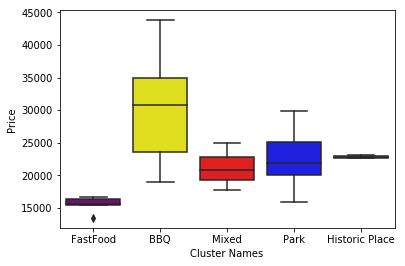

In [114]:
my_colors=['purple','yellow','red','blue','lightgreen']
sns.set_palette(my_colors)
ax = sns.boxplot(x="Cluster Names", y="Price", data=apt_merged[['Cluster Names','Price']])